In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from trans_oil_gas import utils_dataset, utils_attn, utils_fix_seeds, utils_model

Set parameters for plots.

In [2]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

Choose GPU device if it is available.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu = [0] if 'cuda' in device.type else 0
device, gpu

(device(type='cuda'), [0])

Fix all possible seeds for results reproducibility.

In [4]:
utils_fix_seeds.fix_seeds(device=device)

# Read data

Reading of already preprocessed data (here synthetic dataset with the same columns as in the original one is presented).

In [5]:
df = pd.read_csv('../data/synthetic_well_log_data.csv')
df

,DRHO,DENS,GR,DTC,WELLNAME
0,0.01778,2.3794,1.214982,101.5516,26
1,0.01701,2.3705,1.086457,101.6722,26
2,0.01624,2.3615,0.957933,101.7928,26
3,0.01779,2.3593,0.493992,101.1051,26
4,0.02008,2.3591,-0.076734,100.1601,26
...,...,...,...,...,...
730,0.11269,2.6161,0.742381,92.0410,127
731,0.11269,2.6161,0.775581,92.1752,127
732,0.11269,2.6161,0.686798,91.6055,127
733,0.11269,2.6161,0.614402,91.7522,127


In [6]:
slice_len = 100
well_column = "WELLNAME"
save_dir = "./saves/"
log_dir = "./logs/"

# Load pretrained Siamese Transformer

In [7]:
fixed_params_tr = {
    "d_model": 4,
}

In [8]:
with open(os.path.join(save_dir, "best_params_siamese_transformer.json"), "r") as f:
    best_params_tr = json.load(f)
best_params_tr["fc_hidden_size"] = best_params_tr["hidden_size"]
best_params_tr

{'nhead': 1,
 'dim_feedforward': 2048,
 'dropout': 0.48276561038285704,
 'num_layers': 5,
 'hidden_size': 128,
 'fc_hidden_size': 128}

In [9]:
siamese_tr = utils_model.SiameseArchitecture(encoder_type="transformer", **fixed_params_tr, **best_params_tr).float()
siamese_tr.load_state_dict(torch.load(os.path.join(save_dir, "best_siamese_transformer.pth"), map_location=device))
siamese_tr.eval()

SiameseArchitecture(
  (positional_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (self_attn): MultiheadAttention(
          (qkv_proj): Linear(in_features=4, out_features=12, bias=True)
          (o_proj): Linear(in_features=4, out_features=4, bias=True)
        )
        (linear_net): Sequential(
          (0): Linear(in_features=4, out_features=2048, bias=True)
          (1): Dropout(p=0.48276561038285704, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=2048, out_features=4, bias=True)
        )
        (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.48276561038285704, inplace=False)
      )
      (1): EncoderBlock(
        (self_attn): MultiheadAttention(
          (qkv_proj): Linear(in_features=4, out_features=12, bias=True)
          (o_proj): Linear(in_featu

# Generate dataset and create dataloader

In [10]:
_, val_slice_dataset = utils_dataset.generate_datasets(
    df, df,
    well_column='WELLNAME',
    slice_len=slice_len,
    path_to_saves='./saves/',
    results_len_train=0,
    results_len_test=500,
)    

In [11]:
val_dataloader = DataLoader(
    val_slice_dataset, batch_size=64, shuffle=False, num_workers=4
)

# Correlation between attention and gradients

We use central scheme of gradient calculation:

$$ \text{gradient} = \frac{| \text{model}(\text{input} + \delta) - \text{model}(\text{input} - \delta) |}{2 \delta}, $$
where $\delta$ is hyperparameter.

Firstly, we try several deltas and find such $\delta$ using which the correlation coefficient between gradients and attention scores is the highest.

In [12]:
corrs_siamese, corrs_triplet = [], []

for DELTA in tqdm([1e-8, 10]):
    print(DELTA)
    corr_coefs_siamese, corr_coefs_triplet = [], []
    for slice_1, _, _, well in val_dataloader:
        slice_1_plus, slice_1_minus = utils_attn.get_inputs_for_calc_grad(slice_1, DELTA)
     
        gr_1_siamese = utils_attn.get_gradients(slice_1_plus, slice_1_minus, siamese_tr, DELTA, agg=True)
        a_1_siamese = utils_attn.get_attention_scores(slice_1, siamese_tr)

        corr_coefs_siamese.append(
            utils_attn.calc_corr(gr_1_siamese, a_1_siamese)
        )
        
    print(np.array(corr_coefs_siamese).mean(), '±', np.array(corr_coefs_siamese).std(), '\n')
    corrs_siamese.append((DELTA, np.array(corr_coefs_siamese).mean()))

  0%|          | 0/2 [00:00<?, ?it/s]

1e-08


 50%|█████     | 1/2 [00:43<00:43, 43.17s/it]

-0.012534822561422321 ± 0.03155338276595359 

10


100%|██████████| 2/2 [01:27<00:00, 43.86s/it]

0.5626769490133492 ± 0.2483639183775072 



The first tuple in output below consists of delta (which is used in the following experiment) and the highest correlation coefficient.

In [13]:
corrs_siamese_sorted = sorted(corrs_siamese, key=lambda item: item[1], reverse=True)
corrs_siamese_sorted

[(10, 0.5626769490133492), (1e-08, -0.012534822561422321)]

# Eliminating `p` % of interval with the biggest attention (gradient)

In [14]:
DELTA = corrs_siamese_sorted[0][0]
delta_sim_score, accuracies = [], []

drop_0_attn, drop_rand_attn = [], []
drop_0_grad, drop_rand_grad = [], []

# P = [i * 10 for i in range(1, 10)]
P = [i * 10 for i in range(1, 3)]

for p in P:
    for slice_1, positive, negative, well in tqdm(val_dataloader):
        slice_1_g_0, slice_1_a_0, slice_1_r_0 = utils_attn.change_interval_part_with_highest_score(
            slice_1,
            siamese_tr,
            DELTA,
            fill_with='zeros',
            p=p / 100,
            add_baseline=True
        ) 
        slice_1_g_r, slice_1_a_r, slice_1_r_r = utils_attn.change_interval_part_with_highest_score(
            slice_1,
            siamese_tr,
            DELTA,
            fill_with='rand',
            p=p / 100,
            add_baseline=True
        )
        for slice_2, target in zip(
            [positive, negative],
            [torch.ones(slice_1.shape[0]), torch.zeros(slice_1.shape[0])]
        ):
            slice_2_g_0, slice_2_a_0, slice_2_r_0 = utils_attn.change_interval_part_with_highest_score(
                slice_2, 
                siamese_tr,
                DELTA,
                fill_with='zeros',
                p=p / 100,
                add_baseline=True
            ) 
            slice_2_g_r, slice_2_a_r, slice_2_r_r = utils_attn.change_interval_part_with_highest_score(
                slice_2, 
                siamese_tr,
                DELTA,
                fill_with='rand',
                p=p / 100,
                add_baseline=True
            )

            delta_sim_score.extend(
                [
                    (
                        p,
                        'random_0',
                        torch.abs(siamese_tr((slice_1, slice_2)) - siamese_tr((slice_1_r_0, slice_2_r_0))).detach().cpu().numpy().reshape(-1).mean()
                    ),
                    (
                        p,
                        'random_rand',
                        torch.abs(siamese_tr((slice_1, slice_2)) - siamese_tr((slice_1_r_r, slice_2_r_r))).detach().cpu().numpy().reshape(-1).mean()
                    ),
                    (
                        p,
                        'gradient_0',
                        torch.abs(siamese_tr((slice_1, slice_2)) - siamese_tr((slice_1_g_0, slice_2_g_0))).detach().cpu().numpy().reshape(-1).mean()
                    ),
                    (
                        p,
                        'gradient_rand',
                        torch.abs(siamese_tr((slice_1, slice_2)) - siamese_tr((slice_1_g_r, slice_2_g_r))).detach().cpu().numpy().reshape(-1).mean()
                    ),
                    (
                        p,
                        'attention_0',
                        torch.abs(siamese_tr((slice_1, slice_2)) - siamese_tr((slice_1_a_0, slice_2_a_0))).detach().cpu().numpy().reshape(-1).mean()
                    ),
                    (
                        p,
                        'attention_rand',
                        torch.abs(siamese_tr((slice_1, slice_2)) - siamese_tr((slice_1_a_r, slice_2_a_r))).detach().cpu().numpy().reshape(-1).mean()
                    )
                ]
            )

            accuracies.extend(
                [
                    (
                        p,
                        'random_0',
                        utils_attn.get_acc(slice_1, slice_2, siamese_tr, target),
                        utils_attn.get_acc(slice_1_r_0, slice_2_r_0, siamese_tr, target)
                    ),
                    (
                        p,
                        'random_rand',
                        utils_attn.get_acc(slice_1, slice_2, siamese_tr, target),
                        utils_attn.get_acc(slice_1_r_r, slice_2_r_r, siamese_tr, target)
                    ),
                    (
                        p,
                        'gradient_0',
                        utils_attn.get_acc(slice_1, slice_2, siamese_tr, target),
                        utils_attn.get_acc(slice_1_g_0, slice_2_g_0, siamese_tr, target)
                    ),
                    (
                        p,
                        'gradient_rand',
                        utils_attn.get_acc(slice_1, slice_2, siamese_tr, target),
                        utils_attn.get_acc(slice_1_g_r, slice_2_g_r, siamese_tr, target)
                    ),
                    (
                        p,
                        'attention_0',
                        utils_attn.get_acc(slice_1, slice_2, siamese_tr, target),
                        utils_attn.get_acc(slice_1_a_0, slice_2_a_0, siamese_tr, target)
                    ),
                    (
                        p,
                        'attention_rand',
                        utils_attn.get_acc(slice_1, slice_2, siamese_tr, target),
                        utils_attn.get_acc(slice_1_a_r, slice_2_a_r, siamese_tr, target)
                    )
                ]
            )

100%|██████████| 8/8 [11:29<00:00, 86.21s/it]


## Results aggregation

In [15]:
# p -- percent of eliminated elements in interval
df = pd.DataFrame(accuracies, columns=['p', 'type', 'initial_accuracy', 'accuracy'])
df

,p,type,initial_accuracy,accuracy
0,10,random_0,0.0,0.0
1,10,random_rand,0.0,0.0
2,10,gradient_0,0.0,0.0
3,10,gradient_rand,0.0,0.0
4,10,attention_0,0.0,0.0
...,...,...,...,...
187,20,random_rand,1.0,1.0
188,20,gradient_0,1.0,1.0
189,20,gradient_rand,1.0,1.0
190,20,attention_0,1.0,1.0


In [16]:
ans = []

for p in df['p'].unique():
    for t in df['type'].unique():
        df1 = df[(df['p'] == p) & (df['type'] == t)]
        
        ans.append(
            {
                'p': p,
                't': t,
                'initial_acc': df1['initial_accuracy'].mean(),
                'acc': df1['accuracy'].mean()
            }
        )
ans_df = pd.DataFrame(ans)
ans_df

,p,t,initial_acc,acc
0,10,random_0,0.5,0.5
1,10,random_rand,0.5,0.5
2,10,gradient_0,0.5,0.5
3,10,gradient_rand,0.5,0.5
4,10,attention_0,0.5,0.5
5,10,attention_rand,0.5,0.5
6,20,random_0,0.5,0.5
7,20,random_rand,0.5,0.5
8,20,gradient_0,0.5,0.5
9,20,gradient_rand,0.5,0.5


## Results visualization

6it [00:00, 156.16it/s]


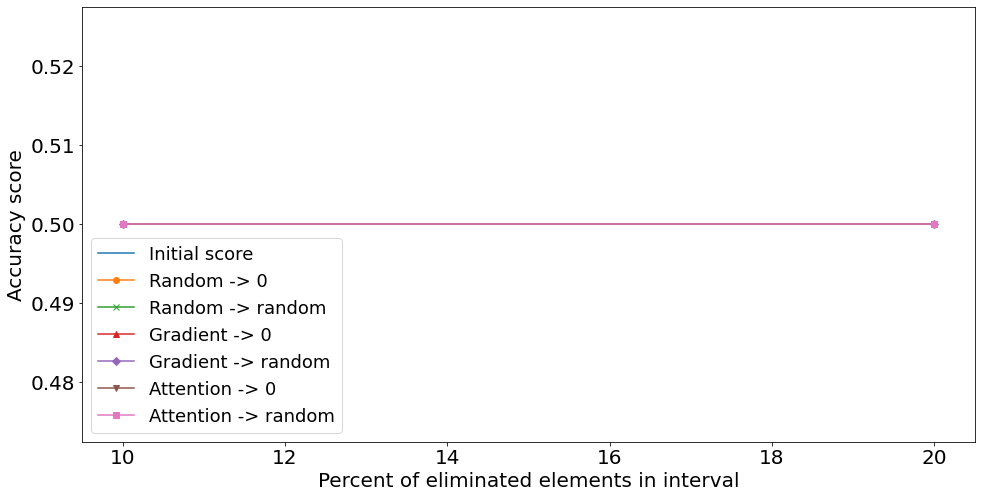

In [17]:
markers = ['o', 'x', '^', 'D', 'v', 's']

plt.figure(figsize=(16, 8))

for i, t in tqdm(enumerate(ans_df['t'].unique())):
    df1 = ans_df[ans_df['t'] == t]
    
    drop_type = t.split('_')
    if drop_type[1] == 'rand':
        drop_type[1] = 'random'
        
    drop_type[0] = drop_type[0][0].upper() + drop_type[0][1:]
    
    if i == 0:
        plt.plot(
            df1['p'].values, 
            df1['initial_acc'].values, 
            label='Initial score'
        )
    
    plt.plot(
        df1['p'].values, 
        df1['acc'].values, 
        label='{} -> {}'.format(drop_type[0], drop_type[1]), 
        marker=markers[i]
    )
    
plt.legend(loc='lower left');
plt.xlabel('Percent of eliminated elements in interval');
plt.ylabel('Accuracy score');